# 1. Set up

In [1]:
# load data

source('setup.R')

df <- readRDS('nsclc_egfr_pm25_09022015.rds') %>% filter(Predicted_Pop == 'EUR') 

In [2]:
OUTCOME <- "EGFR"
COVAR_OF_INTEREST <- "PM25_cat9"
SECONDARY_MUT <- ifelse(OUTCOME == "EGFR", "KRAS", "EGFR")

COVAR_BASELINE <- c(
    "AGE", "GENDER_NM", "PANEL_VERSION", "STAGE", "YEAR_TEST", "SMOKE", 
    "PC1", "PC2", "PC3", "PC4", "PC5", "LUAD"
)
COVAR_TMB <- "MUTATIONAL_BURDEN"
COVAR_SES <- c("avg_pct_poverty", "avg_med_income", "avg_pct_low_edu")

In [3]:
reg_df <- bind_rows(
    df %>% mutate(group = ifelse(SMOKE, 's', 'ns')),
    df %>% mutate(group = 'all')
)

# 2. functions

In [4]:
format_text <- function(rls_df, PRINT = TRUE){
    OR = round(rls_df[1,3], 2)
    pval = formatC(rls_df[1,2], format = "g", digits = 2)
    CI_lower = round(rls_df[1,4], 2)
    CI_upper = round(rls_df[1,5], 2)
    
    if(PRINT){
        print(glue('OR = {OR} (95% CI {CI_lower}-{CI_upper}, p-value = {pval})'))
    }
    
    return(
        list(
            effect = glue('{OR} ({CI_lower}-{CI_upper})'), 
            pval = pval
        )
    
    
    )

}

run_tests <- function(test, formula, data){
    model_list <- list()
    rls_list <- list(test = test)
    for (g in c('all', 'ns','s')){
        model <- glm(formula, data = reg_df %>% filter(group == g), family = binomial())
        rls <- summary_result(model, COVAR_OF_INTEREST, 3)
        model_list[[g]] <- model
        rls_list[[glue('{g}_effect')]] <- format_text(rls, PRINT = FALSE)$effect
        rls_list[[glue('{g}_pval')]] <- format_text(rls, PRINT = FALSE)$pval
    }
    return(data.frame(rls_list))
}

# 3. header

In [5]:
# header 
# ALL NSCLC European patients, 
n_all <- df %>% nrow()
n_non_smoker <- df %>% filter(!SMOKE) %>% nrow()
n_smoker <- df %>% filter(SMOKE) %>% nrow()

cat("Total:", n_all, "| Non-smokers:", n_non_smoker, "| Smokers:", n_smoker, "\n")

dft <- tibble(
    test = character(),
    all_effect= character(),
    all_pval = character(),
    ns_effect = character(),
    ns_pval = character(),
    s_effect = character(),
    s_pval = character()
)

dft

Total: 2312 | Non-smokers: 435 | Smokers: 1877 


test,all_effect,all_pval,ns_effect,ns_pval,s_effect,s_pval
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


# 4. Models: binary PM2.5

In [6]:
COVAR_OF_INTEREST <- "PM25_cat9"

## 4.1 non-adjusted

In [7]:
test <- 'PM2.5 > 9µg/m³'
formula <- as.formula(paste(OUTCOME, "~", COVAR_OF_INTEREST))
cat(test, ':', deparse(formula))
cat('----------------------------------------------------', '\n')
rls_list <- run_tests(test, formula, reg_df)
rls_list
dft <- dft %>% add_row(data.frame(rls_list))

PM2.5 > 9µg/m³ : EGFR ~ PM25_cat9---------------------------------------------------- 


test,all_effect,all_pval,ns_effect,ns_pval,s_effect,s_pval
<chr>,<glue>,<chr>,<glue>,<chr>,<glue>,<chr>
PM2.5 > 9µg/m³,1.79 (1.41-2.25),0,1.74 (1.15-2.64),0.0085,1.57 (1.15-2.12),0.0043


## 4.2 adjusted: COVAR_BASELINE

In [8]:
test <- 'PM2.5 > 9µg/m³ + COVAR_BASELINE'
formula <- as.formula(paste(OUTCOME, "~", paste0(c(COVAR_OF_INTEREST, COVAR_BASELINE), collapse = '+')))
cat(test, ':\n', deparse(formula), '\n')
cat('----------------------------------------------------', '\n')
rls_list <- run_tests(test, formula, reg_df)
rls_list
dft <- dft %>% add_row(data.frame(rls_list))

PM2.5 > 9µg/m³ + COVAR_BASELINE :
 EGFR ~ PM25_cat9 + AGE + GENDER_NM + PANEL_VERSION + STAGE +      YEAR_TEST + SMOKE + PC1 + PC2 + PC3 + PC4 + PC5 + LUAD 
---------------------------------------------------- 


test,all_effect,all_pval,ns_effect,ns_pval,s_effect,s_pval
<chr>,<glue>,<chr>,<glue>,<chr>,<glue>,<chr>
PM2.5 > 9µg/m³ + COVAR_BASELINE,1.69 (1.3-2.19),0.0001,1.74 (1.12-2.72),0.014,1.69 (1.22-2.33),0.0014


## 4.3 adjusted: COVAR_BASELINE + TMB

In [9]:
test <- 'PM2.5 > 9µg/m³ + COVAR_BASELINE + TMB'
formula <- as.formula(paste(OUTCOME, "~", paste0(c(COVAR_OF_INTEREST, COVAR_BASELINE, COVAR_TMB), collapse = '+')))
cat(test, ':\n', deparse(formula), '\n')
cat('----------------------------------------------------', '\n')
rls_list <- run_tests(test, formula, reg_df)
rls_list
dft <- dft %>% add_row(data.frame(rls_list))

PM2.5 > 9µg/m³ + COVAR_BASELINE + TMB :
 EGFR ~ PM25_cat9 + AGE + GENDER_NM + PANEL_VERSION + STAGE +      YEAR_TEST + SMOKE + PC1 + PC2 + PC3 + PC4 + PC5 + LUAD +      MUTATIONAL_BURDEN 
---------------------------------------------------- 


test,all_effect,all_pval,ns_effect,ns_pval,s_effect,s_pval
<chr>,<glue>,<chr>,<glue>,<chr>,<glue>,<chr>
PM2.5 > 9µg/m³ + COVAR_BASELINE + TMB,1.62 (1.24-2.1),0.0003,1.74 (1.12-2.73),0.014,1.57 (1.12-2.18),0.0081


## 4.4 adjusted: COVAR_BASELINE + TMB + SES

In [10]:
test <- 'PM2.5 > 9µg/m³ + COVAR_BASELINE + TMB + SES'
formula <- as.formula(paste(OUTCOME, "~", paste0(c(COVAR_OF_INTEREST, COVAR_BASELINE, COVAR_TMB, COVAR_SES), collapse = '+')))
cat(test, ':\n', deparse(formula), '\n')
cat('----------------------------------------------------', '\n')
rls_list <- run_tests(test, formula, reg_df)
rls_list
dft <- dft %>% add_row(data.frame(rls_list))

PM2.5 > 9µg/m³ + COVAR_BASELINE + TMB + SES :
 EGFR ~ PM25_cat9 + AGE + GENDER_NM + PANEL_VERSION + STAGE +      YEAR_TEST + SMOKE + PC1 + PC2 + PC3 + PC4 + PC5 + LUAD +      MUTATIONAL_BURDEN + avg_pct_poverty + avg_med_income + avg_pct_low_edu 
---------------------------------------------------- 


test,all_effect,all_pval,ns_effect,ns_pval,s_effect,s_pval
<chr>,<glue>,<chr>,<glue>,<chr>,<glue>,<chr>
PM2.5 > 9µg/m³ + COVAR_BASELINE + TMB + SES,1.66 (1.25-2.2),0.0005,1.69 (1.04-2.73),0.033,1.66 (1.15-2.37),0.006


## 4.5 adjusted: COVAR_BASELINE + TMB + SES + SECONDARY_MUT

In [11]:
test <- glue('PM2.5 > 9µg/m³ + COVAR_BASELINE + TMB + SES + {SECONDARY_MUT}')
formula <- as.formula(paste(OUTCOME, "~", paste0(c(COVAR_OF_INTEREST, COVAR_BASELINE, COVAR_TMB, COVAR_SES, SECONDARY_MUT), collapse = '+')))
cat(test, ':\n', deparse(formula), '\n')
cat('----------------------------------------------------', '\n')
rls_list <- run_tests(test, formula, reg_df)
rls_list
dft <- dft %>% add_row(data.frame(rls_list))

PM2.5 > 9µg/m³ + COVAR_BASELINE + TMB + SES + KRAS :
 EGFR ~ PM25_cat9 + AGE + GENDER_NM + PANEL_VERSION + STAGE +      YEAR_TEST + SMOKE + PC1 + PC2 + PC3 + PC4 + PC5 + LUAD +      MUTATIONAL_BURDEN + avg_pct_poverty + avg_med_income + avg_pct_low_edu +      KRAS 
---------------------------------------------------- 


test,all_effect,all_pval,ns_effect,ns_pval,s_effect,s_pval
<glue>,<glue>,<chr>,<glue>,<chr>,<glue>,<chr>
PM2.5 > 9µg/m³ + COVAR_BASELINE + TMB + SES + KRAS,1.55 (1.14-2.11),0.0055,1.63 (0.97-2.77),0.065,1.54 (1.03-2.29),0.033


# 5 Linear PM2.5

In [12]:
COVAR_OF_INTEREST = 'PM25'

## 5.1 non-adjusted

In [13]:
test <- 'PM2.5'
formula <- as.formula(paste(OUTCOME, "~", paste0(c(COVAR_OF_INTEREST), collapse = '+')))
cat(test, ':\n', deparse(formula), '\n')
cat('----------------------------------------------------', '\n')
rls_list <- run_tests(test, formula, reg_df)
rls_list
dft <- dft %>% add_row(data.frame(rls_list))

PM2.5 :
 EGFR ~ PM25 
---------------------------------------------------- 


test,all_effect,all_pval,ns_effect,ns_pval,s_effect,s_pval
<chr>,<glue>,<chr>,<glue>,<chr>,<glue>,<chr>
PM2.5,1.16 (1.07-1.27),0.0006,1.2 (1.05-1.38),0.0078,1.07 (0.95-1.2),0.28


## 5.2 adjusted: COVAR_BASELINE 

In [14]:
test <- 'PM2.5 + COVAR_BASELINE'
formula <- as.formula(paste(OUTCOME, "~", paste0(c(COVAR_OF_INTEREST, COVAR_BASELINE), collapse = '+')))
cat(test, ':\n', deparse(formula), '\n')
cat('----------------------------------------------------', '\n')
rls_list <- run_tests(test, formula, reg_df)
rls_list
dft <- dft %>% add_row(data.frame(rls_list))

PM2.5 + COVAR_BASELINE :
 EGFR ~ PM25 + AGE + GENDER_NM + PANEL_VERSION + STAGE + YEAR_TEST +      SMOKE + PC1 + PC2 + PC3 + PC4 + PC5 + LUAD 
---------------------------------------------------- 


test,all_effect,all_pval,ns_effect,ns_pval,s_effect,s_pval
<chr>,<glue>,<chr>,<glue>,<chr>,<glue>,<chr>
PM2.5 + COVAR_BASELINE,1.11 (1.02-1.22),0.021,1.19 (1.03-1.38),0.017,1.06 (0.94-1.21),0.31


## 5.3 adjusted: COVAR_BASELINE + TMB

In [15]:
test <- 'PM2.5 + COVAR_BASELINE + TMB'
formula <- as.formula(paste(OUTCOME, "~", paste0(c(COVAR_OF_INTEREST, COVAR_BASELINE, COVAR_TMB), collapse = '+')))
cat(test, ':\n', deparse(formula), '\n')
cat('----------------------------------------------------', '\n')
rls_list <- run_tests(test, formula, reg_df)
rls_list
dft <- dft %>% add_row(data.frame(rls_list))

PM2.5 + COVAR_BASELINE + TMB :
 EGFR ~ PM25 + AGE + GENDER_NM + PANEL_VERSION + STAGE + YEAR_TEST +      SMOKE + PC1 + PC2 + PC3 + PC4 + PC5 + LUAD + MUTATIONAL_BURDEN 
---------------------------------------------------- 


test,all_effect,all_pval,ns_effect,ns_pval,s_effect,s_pval
<chr>,<glue>,<chr>,<glue>,<chr>,<glue>,<chr>
PM2.5 + COVAR_BASELINE + TMB,1.1 (1-1.21),0.043,1.21 (1.04-1.4),0.012,1.05 (0.93-1.19),0.46


## 5.4 adjusted: COVAR_BASELINE + TMB + SES

In [16]:
test <- 'PM2.5 + COVAR_BASELINE + TMB + SES'
formula <- as.formula(paste(OUTCOME, "~", paste0(c(COVAR_OF_INTEREST, COVAR_BASELINE, COVAR_TMB, COVAR_SES), collapse = '+')))
cat(test, ':\n', deparse(formula), '\n')
cat('----------------------------------------------------', '\n')
rls_list <- run_tests(test, formula, reg_df)
rls_list
dft <- dft %>% add_row(data.frame(rls_list))

PM2.5 + COVAR_BASELINE + TMB + SES :
 EGFR ~ PM25 + AGE + GENDER_NM + PANEL_VERSION + STAGE + YEAR_TEST +      SMOKE + PC1 + PC2 + PC3 + PC4 + PC5 + LUAD + MUTATIONAL_BURDEN +      avg_pct_poverty + avg_med_income + avg_pct_low_edu 
---------------------------------------------------- 


test,all_effect,all_pval,ns_effect,ns_pval,s_effect,s_pval
<chr>,<glue>,<chr>,<glue>,<chr>,<glue>,<chr>
PM2.5 + COVAR_BASELINE + TMB + SES,1.1 (1-1.22),0.058,1.19 (1.02-1.39),0.029,1.06 (0.93-1.21),0.39


## 5.5 adjusted: COVAR_BASELINE + TMB + SES + SECONDARY_COVAR

In [17]:
test <- 'PM2.5 + KRAS + COVAR_BASELINE + TMB + SES'
formula <- as.formula(paste(OUTCOME, "~", paste0(c(COVAR_OF_INTEREST, COVAR_BASELINE, COVAR_TMB, COVAR_SES, SECONDARY_MUT), collapse = '+')))
cat(test, ':\n', deparse(formula), '\n')
cat('----------------------------------------------------', '\n')
rls_list <- run_tests(test, formula, reg_df)
rls_list
dft <- dft %>% add_row(data.frame(rls_list))

PM2.5 + KRAS + COVAR_BASELINE + TMB + SES :
 EGFR ~ PM25 + AGE + GENDER_NM + PANEL_VERSION + STAGE + YEAR_TEST +      SMOKE + PC1 + PC2 + PC3 + PC4 + PC5 + LUAD + MUTATIONAL_BURDEN +      avg_pct_poverty + avg_med_income + avg_pct_low_edu + KRAS 
---------------------------------------------------- 


test,all_effect,all_pval,ns_effect,ns_pval,s_effect,s_pval
<chr>,<glue>,<chr>,<glue>,<chr>,<glue>,<chr>
PM2.5 + KRAS + COVAR_BASELINE + TMB + SES,1.09 (0.98-1.21),0.11,1.15 (0.98-1.36),0.09,1.08 (0.94-1.24),0.3


# summary

In [18]:
smry <- dft
colnames(smry) <- c(
    'test',
    glue('all_effect N = {n_all}'),
    'all_pval',
    glue('non_smoker_effect N = {n_non_smoker}'),
    'non_smoker_pval'
    ,
    glue('smoker_effect N = {n_smoker}'),
    'smoker_pval'
)
smry

test,all_effect N = 2312,all_pval,non_smoker_effect N = 435,non_smoker_pval,smoker_effect N = 1877,smoker_pval
<glue>,<glue>,<chr>,<glue>,<chr>,<glue>,<chr>
PM2.5 > 9µg/m³,1.79 (1.41-2.25),0,1.74 (1.15-2.64),0.0085,1.57 (1.15-2.12),0.0043
PM2.5 > 9µg/m³ + COVAR_BASELINE,1.69 (1.3-2.19),0.0001,1.74 (1.12-2.72),0.014,1.69 (1.22-2.33),0.0014
PM2.5 > 9µg/m³ + COVAR_BASELINE + TMB,1.62 (1.24-2.1),0.0003,1.74 (1.12-2.73),0.014,1.57 (1.12-2.18),0.0081
PM2.5 > 9µg/m³ + COVAR_BASELINE + TMB + SES,1.66 (1.25-2.2),0.0005,1.69 (1.04-2.73),0.033,1.66 (1.15-2.37),0.006
PM2.5 > 9µg/m³ + COVAR_BASELINE + TMB + SES + KRAS,1.55 (1.14-2.11),0.0055,1.63 (0.97-2.77),0.065,1.54 (1.03-2.29),0.033
PM2.5,1.16 (1.07-1.27),0.0006,1.2 (1.05-1.38),0.0078,1.07 (0.95-1.2),0.28
PM2.5 + COVAR_BASELINE,1.11 (1.02-1.22),0.021,1.19 (1.03-1.38),0.017,1.06 (0.94-1.21),0.31
PM2.5 + COVAR_BASELINE + TMB,1.1 (1-1.21),0.043,1.21 (1.04-1.4),0.012,1.05 (0.93-1.19),0.46
PM2.5 + COVAR_BASELINE + TMB + SES,1.1 (1-1.22),0.058,1.19 (1.02-1.39),0.029,1.06 (0.93-1.21),0.39


In [19]:
file_name <- glue('result/glm_{OUTCOME}_association')

saveRDS(smry, paste0(file_name, ".rds"))
write_tsv(smry, paste0(file_name, ".tsv"))

# 6. Tree plot for default model 

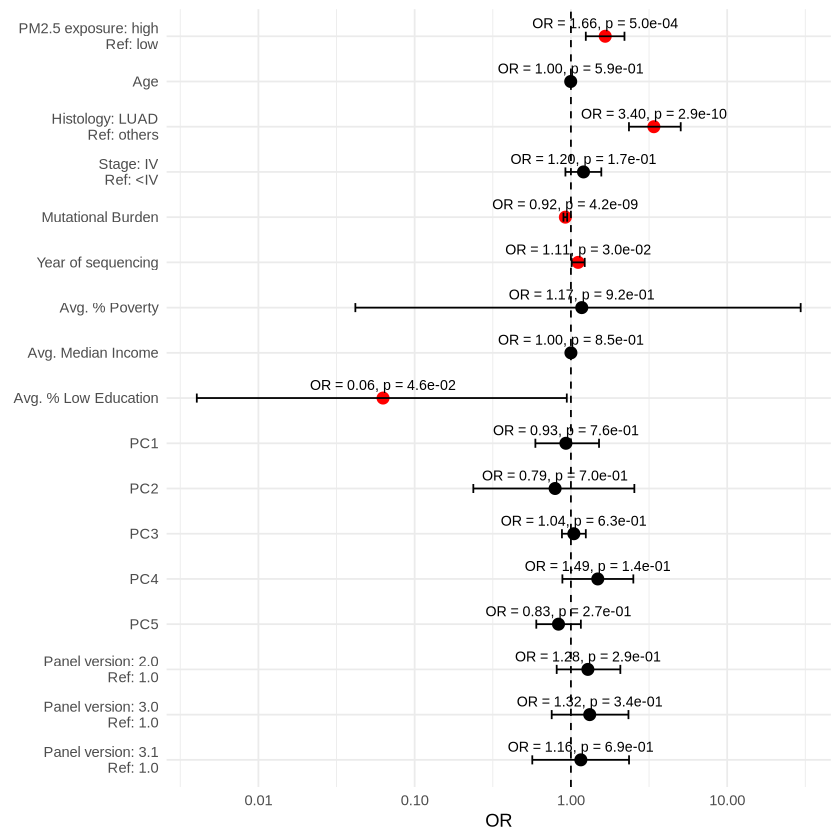

In [20]:
library(broom)
library(dplyr)
library(ggplot2)

# fit model 
COVAR_OF_INTEREST <- 'PM25_cat9'
formula <- as.formula(paste(OUTCOME, "~", paste0(c(COVAR_OF_INTEREST, COVAR_BASELINE, COVAR_TMB, COVAR_SES), collapse = '+')))
model <- glm(formula, data = df, family = binomial())


# Custom labels (same as before)
to_select <- c(
  'PM25_cat9'         = 'PM2.5 exposure: high\nRef: low',
  'GENDER_NMFEMALE'   = 'Gender: female\nRef: male',
  'AGE'               = 'Age',
  'SMOKE3TRUE'        = 'Smoking: Former/Current smokers\nRef: Never smokers',
    'pkys' = 'Smoking pack-years',
  'LUADTRUE'          = 'Histology: LUAD\nRef: others',
  'STAGETRUE'         = 'Stage: IV\nRef: <IV',
  'MUTATIONAL_BURDEN' = 'Mutational Burden',
  'YEAR_TEST'         = 'Year of sequencing',
  'avg_pct_poverty'   = 'Avg. % Poverty',
  'avg_med_income'    = 'Avg. Median Income',
  'avg_pct_low_edu'   = 'Avg. % Low Education',
  'PC1'               = 'PC1',
  'PC2'               = 'PC2',
  'PC3'               = 'PC3',
  'PC4'               = 'PC4',
  'PC5'               = 'PC5',
  'PANEL_VERSION2'    = 'Panel version: 2.0\nRef: 1.0',
  'PANEL_VERSION3'    = 'Panel version: 3.0\nRef: 1.0',
  'PANEL_VERSION3.1'  = 'Panel version: 3.1\nRef: 1.0'
)

# Tidy model and relabel
plot_df <- tidy(model, conf.int = TRUE) %>%
  filter(term %in% names(to_select)) %>%
  mutate(
    OR        = exp(estimate),
    OR_low    = exp(conf.low),
    OR_high   = exp(conf.high),
    label     = to_select[term],
    label     = factor(label, levels = rev(to_select))
  )

options(repr.plot.height = 7, repr.plot.width = 7)
# Plot OR on log scale
ggplot(plot_df, aes(x = OR, y = label)) +
  geom_point(aes(color = p.value < 0.05), size = 3) +
  geom_errorbarh(aes(xmin = OR_low, xmax = OR_high), height = 0.2) +
  geom_vline(xintercept = 1, linetype = "dashed") +
  geom_text(aes(label = sprintf("OR = %.2f, p = %.1e", OR, p.value)),
            vjust = -0.8, size = 3) +
  scale_x_log10() +
  scale_color_manual(values = c("TRUE" = "red", "FALSE" = "black")) +
  labs(
    x = "OR",
    y = NULL,
  ) +
  theme_minimal() +
  theme(legend.position = "none")
ggsave('result/multiregresion-tree.pdf', h = 7, w = 7)